In [1]:
import os
global path
path = os.getcwd()

import numpy as np
import pandas as pd
import pandas_profiling as pp
import calendar as cal
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


from IPython.core.display import HTML
%matplotlib inline
print(path)

C:\Users\Abhinav\M.A.S.T.E.R.S M.A.T.E.R.I.A.L\3. S.E.M.E.S.T.E.R - 3\A.D.S\Assignments\Case 2 - Energy Dataset


In [2]:
df = pd.read_csv('https://s3.us-east-2.amazonaws.com/ads-demo1/E_Dataset.csv',parse_dates=['date'])

In [3]:
pp.ProfileReport(df)

Number of variables,29
Number of observations,19735
Total Missing (%),0.0%
Total size in memory,4.4 MiB
Average record size in memory,232.0 B
Numeric,25
Categorical,0
Date,1
Text (Unique),0
Rejected,3
Distinct count,92


## Feature Engineering

In [4]:
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['weekNumberInYear'] = df['date'].dt.week
df['dayOfMonth'] = df['date'].dt.day
df['dayInWeek'] = df['date'].dt.dayofweek.apply(lambda x : cal.day_name[x])
df['hourOfDay'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

df['WeekendFlag'] = df['dayInWeek'].apply(lambda x : 1 if (x == 'Saturday') or (x == 'Sunday') else 0).astype('int64')
df['TotalSecondsMidnight'] = (df['date'].dt.hour * 3600) + (df['date'].dt.minute * 60) + (df['date'].dt.second)

dayInWeek = pd.get_dummies(df.dayInWeek,prefix='dayInWeek').astype('int64')
weekendflag = pd.get_dummies(df.WeekendFlag,prefix='weekendflag').astype('int64')

df = pd.concat([df,dayInWeek,weekendflag],axis=1)

In [5]:
features = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 
            'T3','RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8','RH_8', 'T9', 'RH_9', 
            'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint','TotalSecondsMidnight', 
            'dayInWeek_Friday','dayInWeek_Monday', 'dayInWeek_Saturday', 'dayInWeek_Sunday','dayInWeek_Thursday', 'dayInWeek_Tuesday', 'dayInWeek_Wednesday',
            'weekendflag_0', 'weekendflag_1']

In [6]:
df = df[features]

In [7]:
display(HTML(df.head().to_html()))

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,61200,0,1,0,0,0,0,0,1,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,61800,0,1,0,0,0,0,0,1,0
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,62400,0,1,0,0,0,0,0,1,0
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,63000,0,1,0,0,0,0,0,1,0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,63600,0,1,0,0,0,0,0,1,0


## Train Test Splitting of the Dataframe

In [8]:
X = df.drop('Appliances',axis=1)
y = df['Appliances']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

- Initially, we will use 3 'vanilla' models of Random Forests, Neural Networks and Linear regressors to asses their performance.  
- When we identify the best among the three models, we can proceed ahead to see how we can further enhance its performance.  

## Prediction Models

In [9]:
lm = LinearRegression()
rf = RandomForestRegressor()
nn = MLPRegressor()

- We can see that the data in the **TotalSecondsMidnight** column is not up to scale as compared to other columns.  
- We should scale the dataset before we can plug it in our models for further evaluation.  
- We use the **MinMax scaler** for the job because if we use StandardScaler then some values in the dataset are scaled to -ve, which can give a -ve score for the neural networks.

In [10]:
#Reshaping y to fit the scaler
yte = np.array(y_test).reshape(len(y_test),1)
ytr = np.array(y_train).reshape(len(y_train),1)

scaler = MinMaxScaler()

X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

y_train_scaled = scaler.fit_transform(ytr).ravel()
y_test_scaled = scaler.fit_transform(yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
lm.fit(X_train_scaled,y_train_scaled)
rf.fit(X_train_scaled,y_train_scaled)
nn.fit(X_train_scaled,y_train_scaled)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [12]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
error_metric = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})

def model_stats(model,model_name):
    global error_metric
    
    test_data_predictions = model.predict(X_test_scaled)
    train_data_predictions = model.predict(X_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(y_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(y_test_scaled,test_data_predictions)
    
    #MAPE
    model_mape_train = mean_absolute_percentage_error(y_train_scaled,train_data_predictions)
    model_mape_test = mean_absolute_percentage_error(y_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(y_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(y_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(y_train_scaled,train_data_predictions)
    model_r2_test = r2_score(y_test_scaled,test_data_predictions)
    
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test],
                            'mape_train':[model_mape_train],
                            'mape_test':[model_mape_test]})
    
    error_metric = pd.concat([error_metric, df_local],sort=True)
    return error_metric

In [14]:
model_stats(lm,'LR')
model_stats(rf,'RF')
model_stats(nn,'NN')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,inf,inf,0.112461,0.171898,0.113008,0.086958
0,RF,0.054201,0.012752,inf,inf,0.283058,0.910285,0.101568,0.028622
0,NN,0.072913,0.055380,inf,inf,0.144666,0.185775,0.110938,0.086226


## Hyper Parameter Tuning Using GridSearchCV

In [15]:
param_grid_rf = {'n_estimators':[5,15,30],
                'bootstrap':[True,False],
                'max_depth':[1,10,30]}

param_grid_nn = {'activation': ['tanh', 'relu'], 
                 'solver': ['sgd', 'adam'], 
                 'alpha': [0.0001, 0.05], 
                 'learning_rate': ['constant','adaptive']}

In [16]:
nn_grid = GridSearchCV(MLPRegressor(),
                       param_grid=param_grid_nn,
                       n_jobs=-1,cv=3,
                       refit=True)

nn_grid.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.05], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
nn_grid.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'learning_rate': 'constant',
 'solver': 'adam'}

In [18]:
model_stats(nn_grid,'Tuned NN Regressor')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,inf,inf,0.112461,0.171898,0.113008,0.086958
0,RF,0.054201,0.012752,inf,inf,0.283058,0.910285,0.101568,0.028622
0,NN,0.072913,0.055380,inf,inf,0.144666,0.185775,0.110938,0.086226
0,Tuned NN Regressor,0.062339,0.048888,inf,inf,0.195843,0.218646,0.107568,0.084467


In [19]:
rf_grid = GridSearchCV(RandomForestRegressor(),
                       param_grid=param_grid_rf,
                       n_jobs=-1,cv=3,refit=True)

rf_grid.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 10, 30], 'n_estimators': [5, 15, 30], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 30, 'n_estimators': 30}

In [21]:
model_stats(rf_grid,'Tuned RF Regressor')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,inf,inf,0.112461,0.171898,0.113008,0.086958
0,RF,0.054201,0.012752,inf,inf,0.283058,0.910285,0.101568,0.028622
0,NN,0.072913,0.055380,inf,inf,0.144666,0.185775,0.110938,0.086226
0,Tuned NN Regressor,0.062339,0.048888,inf,inf,0.195843,0.218646,0.107568,0.084467
0,Tuned RF Regressor,0.049123,0.011973,inf,inf,0.380414,0.928983,0.094420,0.025465


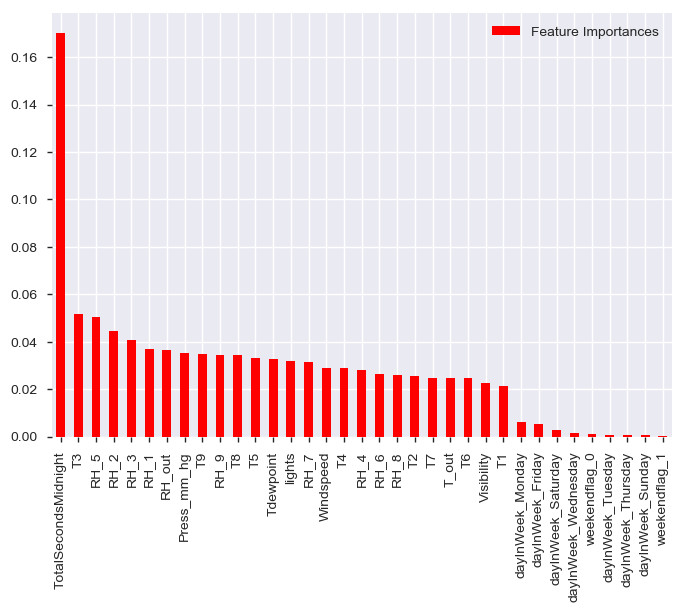

In [22]:
pd.DataFrame(rf.feature_importances_,
             index=X_train.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

## Removing Light Column to Evaluate Models

In [23]:
featuresNoLights = features[2:]
featuresNoLights.append('Appliances')

In [24]:
df_NL = df[featuresNoLights]

In [25]:
display(HTML(df_NL.head().to_html()))

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1,Appliances
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,61200,0,1,0,0,0,0,0,1,0,60
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,61800,0,1,0,0,0,0,0,1,0,60
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,62400,0,1,0,0,0,0,0,1,0,50
3,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,63000,0,1,0,0,0,0,0,1,0,50
4,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,63600,0,1,0,0,0,0,0,1,0,60


In [26]:
X_NL = df_NL.drop('Appliances',axis=1)
y_NL = df_NL['Appliances']

X_train_NL, X_test_NL, y_train_NL, y_test_NL = train_test_split(X_NL, y_NL, test_size=0.30, random_state=101)

In [27]:
nl_yte = np.array(y_test_NL).reshape(len(y_test_NL),1)
nl_ytr = np.array(y_train_NL).reshape(len(y_train_NL),1)


X_NL_train_scaled = scaler.fit_transform(X_train_NL)
X_NL_test_scaled = scaler.fit_transform(X_test_NL)

Y_NL_train_scaled = scaler.fit_transform(nl_ytr).ravel()
Y_NL_test_scaled = scaler.fit_transform(nl_yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
error_metric_nl = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})

def model_stats_NL(model,model_name):
    global error_metric_nl
    
    test_data_predictions = model.predict(X_NL_test_scaled)
    train_data_predictions = model.predict(X_NL_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(Y_NL_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(Y_NL_test_scaled,test_data_predictions)
    
    #MAPE
    model_mape_train = mean_absolute_percentage_error(Y_NL_train_scaled,train_data_predictions)
    model_mape_test = mean_absolute_percentage_error(Y_NL_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(Y_NL_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(Y_NL_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(Y_NL_train_scaled,train_data_predictions)
    model_r2_test = r2_score(Y_NL_test_scaled,test_data_predictions)
    
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test],
                            'mape_train':[model_mape_train],
                            'mape_test':[model_mape_test]})
    
    error_metric_nl = pd.concat([error_metric_nl, df_local],sort=True)
    return error_metric_nl

In [29]:
nl_lm = LinearRegression()
nl_lm.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats_NL(nl_lm,'No Light Linear Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Light Linear Model,0.077437,0.049702,inf,inf,0.106227,0.151344,0.113404,0.08803


In [30]:
nl_rf = RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=30)
nl_rf.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats_NL(nl_rf,'No Light RF Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Light Linear Model,0.077437,0.049702,inf,inf,0.106227,0.151344,0.113404,0.08803
0,No Light RF Model,0.045849,0.011179,inf,inf,0.443007,0.936499,0.089524,0.02408


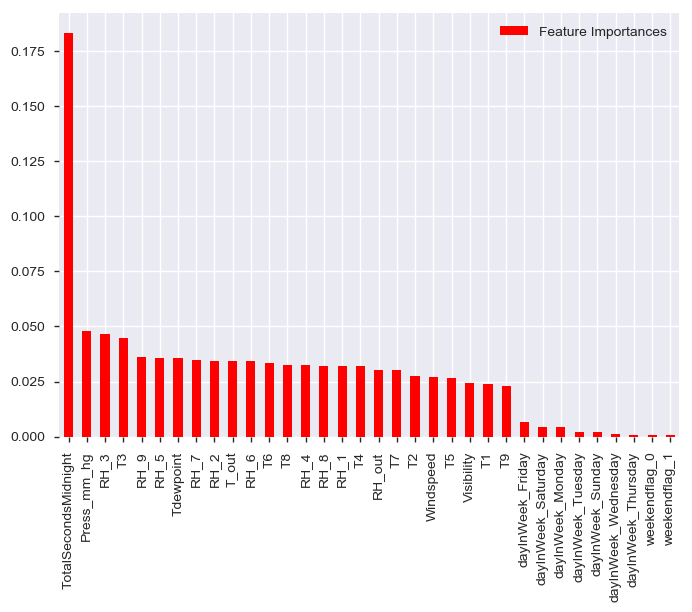

In [31]:
pd.DataFrame(nl_rf.feature_importances_,
             index=X_train_NL.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

In [32]:
nl_nn = MLPRegressor(activation='relu',
                     alpha=0.05,
                     learning_rate='adaptive',
                     solver='adam')
nl_nn.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats_NL(nl_nn,'No Light NN Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Light Linear Model,0.077437,0.049702,inf,inf,0.106227,0.151344,0.113404,0.088030
0,No Light RF Model,0.045849,0.011179,inf,inf,0.443007,0.936499,0.089524,0.024080
0,No Light NN Model,0.072537,0.058293,inf,inf,0.167270,0.168770,0.109463,0.087122


We can observe that after removing the Light column, the model and their efficacy is reduced, hence we can deduce that even though the light column has many zeros it does contribute to the predictions and makes them slightly better.

## Removing Lights and Weather Related Columns to Evaluate Models

In [33]:
features_no_weather = featuresNoLights

for item in ['T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint']:
    features_no_weather.remove(item)

In [34]:
df_NW = df[features_no_weather]

In [35]:
display(HTML(df_NW.head().to_html()))

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1,Appliances
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,61200,0,1,0,0,0,0,0,1,0,60
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,61800,0,1,0,0,0,0,0,1,0,60
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,62400,0,1,0,0,0,0,0,1,0,50
3,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,63000,0,1,0,0,0,0,0,1,0,50
4,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,63600,0,1,0,0,0,0,0,1,0,60


In [36]:
X_NW = df_NW.drop('Appliances',axis=1)
y_NW = df_NW['Appliances']

X_train_NW, X_test_NW, y_train_NW, y_test_NW = train_test_split(X_NW, y_NW, test_size=0.30, random_state=101)

In [37]:
nw_yte = np.array(y_test_NW).reshape(len(y_test_NW),1)
nw_ytr = np.array(y_train_NW).reshape(len(y_train_NW),1)


X_NW_train_scaled = scaler.fit_transform(X_train_NW)
X_NW_test_scaled = scaler.fit_transform(X_test_NW)

Y_NW_train_scaled = scaler.fit_transform(nw_ytr).ravel()
Y_NW_test_scaled = scaler.fit_transform(nw_yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
error_metric_nw = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})

def model_stats_NW(model,model_name):
    global error_metric_nw
    
    test_data_predictions = model.predict(X_NW_test_scaled)
    train_data_predictions = model.predict(X_NW_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(Y_NW_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(Y_NW_test_scaled,test_data_predictions)
    
    #MAPE
    model_mape_train = mean_absolute_percentage_error(Y_NW_train_scaled,train_data_predictions)
    model_mape_test = mean_absolute_percentage_error(Y_NW_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(Y_NW_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(Y_NW_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(Y_NW_train_scaled,train_data_predictions)
    model_r2_test = r2_score(Y_NW_test_scaled,test_data_predictions)
    
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test],
                            'mape_train':[model_mape_train],
                            'mape_test':[model_mape_test]})
    
    error_metric_nw = pd.concat([error_metric_nw, df_local],sort=True)
    return error_metric_nw

In [39]:
nw_lm = LinearRegression()
nw_lm.fit(X_NW_train_scaled,Y_NW_train_scaled)
model_stats_NW(nw_lm,'No Weather & Light Linear Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Weather & Light Linear Model,0.078171,0.049927,inf,inf,0.098192,0.143801,0.113912,0.08842


In [40]:
nw_rf = RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=30)
nw_rf.fit(X_NW_train_scaled,Y_NW_train_scaled)
model_stats_NW(nw_rf,'No Weather & Light RF Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Weather & Light Linear Model,0.078171,0.049927,inf,inf,0.098192,0.143801,0.113912,0.088420
0,No Weather & Light RF Model,0.048159,0.011391,inf,inf,0.420727,0.933986,0.091297,0.024552


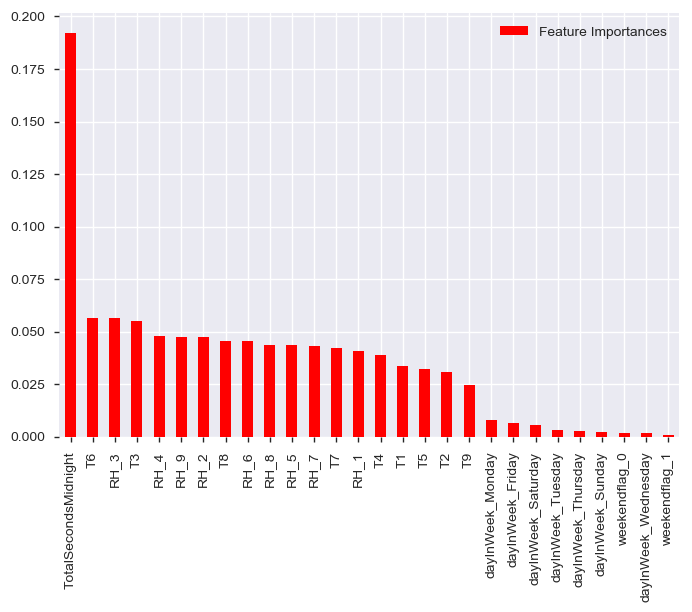

In [41]:
pd.DataFrame(nw_rf.feature_importances_,
             index=X_train_NW.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

In [42]:
nw_nn = MLPRegressor(activation='relu',
                     alpha=0.05,
                     learning_rate='adaptive',
                     solver='adam')
nw_nn.fit(X_NW_train_scaled,Y_NW_train_scaled)
model_stats_NW(nw_nn,'No Weather & Light NN Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Weather & Light Linear Model,0.078171,0.049927,inf,inf,0.098192,0.143801,0.113912,0.088420
0,No Weather & Light RF Model,0.048159,0.011391,inf,inf,0.420727,0.933986,0.091297,0.024552
0,No Weather & Light NN Model,0.058894,0.043600,inf,inf,0.190399,0.184721,0.107932,0.086282


## Removing Temperature and Humidity Inside the House

In [43]:
features_TH = features 

for item in ['T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9','Visibility']:
    features_TH.remove(item)


In [44]:
df_TH = df[features_TH]
display(HTML(df_TH.head().to_html()))

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1
0,60,30,6.600000,733.5,92.0,7.000000,5.3,61200,0,1,0,0,0,0,0,1,0
1,60,30,6.483333,733.6,92.0,6.666667,5.2,61800,0,1,0,0,0,0,0,1,0
2,50,30,6.366667,733.7,92.0,6.333333,5.1,62400,0,1,0,0,0,0,0,1,0
3,50,40,6.250000,733.8,92.0,6.000000,5.0,63000,0,1,0,0,0,0,0,1,0
4,60,40,6.133333,733.9,92.0,5.666667,4.9,63600,0,1,0,0,0,0,0,1,0


In [45]:
X_TH = df_TH.drop('Appliances',axis=1)
y_TH = df_TH['Appliances']

X_train_TH, X_test_TH, y_train_TH, y_test_TH = train_test_split(X_TH, y_TH, test_size=0.30, random_state=101)

In [46]:
th_yte = np.array(y_test_TH).reshape(len(y_test_TH),1)
th_ytr = np.array(y_train_TH).reshape(len(y_train_TH),1)


X_TH_train_scaled = scaler.fit_transform(X_train_TH)
X_TH_test_scaled = scaler.fit_transform(X_test_TH)

Y_TH_train_scaled = scaler.fit_transform(th_ytr).ravel()
Y_TH_test_scaled = scaler.fit_transform(th_yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
error_metric_th = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})

def model_stats_TH(model,model_name):
    global error_metric_th
    
    test_data_predictions = model.predict(X_TH_test_scaled)
    train_data_predictions = model.predict(X_TH_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(Y_TH_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(Y_TH_test_scaled,test_data_predictions)
    
    #MAPE
    model_mape_train = mean_absolute_percentage_error(Y_TH_train_scaled,train_data_predictions)
    model_mape_test = mean_absolute_percentage_error(Y_TH_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(Y_TH_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(Y_TH_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(Y_TH_train_scaled,train_data_predictions)
    model_r2_test = r2_score(Y_TH_test_scaled,test_data_predictions)
    
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test],
                            'mape_train':[model_mape_train],
                            'mape_test':[model_mape_test]})
    
    error_metric_th = pd.concat([error_metric_th, df_local],sort=True)
    return error_metric_th

In [48]:
th_lm = LinearRegression()
th_lm.fit(X_TH_train_scaled,Y_TH_train_scaled)
model_stats_TH(th_lm,'No Outside T & RH Linear Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Outside T & RH Linear Model,0.059646,0.050956,inf,inf,0.062131,0.094869,0.116168,0.090912


In [49]:
th_rf = RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=30)
th_rf.fit(X_TH_train_scaled,Y_TH_train_scaled)
model_stats_TH(th_rf,'No Outside T & RH RF Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Outside T & RH Linear Model,0.059646,0.050956,inf,inf,0.062131,0.094869,0.116168,0.090912
0,No Outside T & RH RF Model,0.041477,0.011970,inf,inf,0.444724,0.928005,0.089386,0.025640


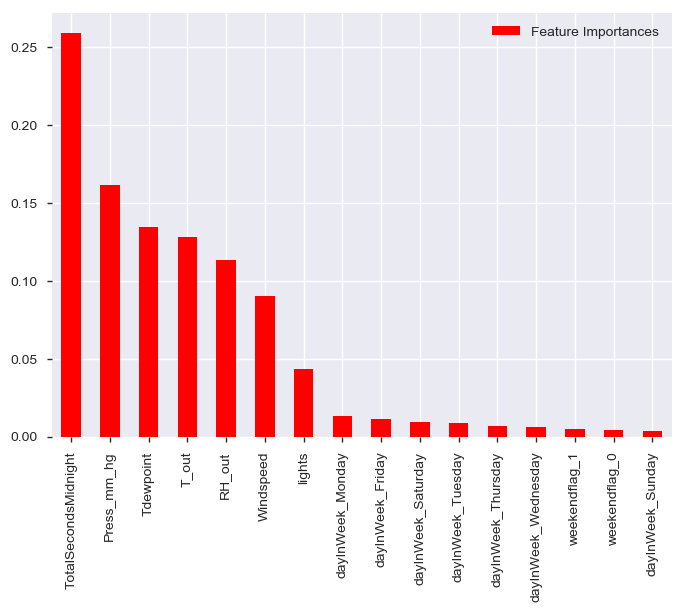

In [50]:
pd.DataFrame(th_rf.feature_importances_,
             index=X_train_TH.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

In [51]:
th_nn = MLPRegressor(activation='relu',
                     alpha=0.05,
                     learning_rate='adaptive',
                     solver='adam')
th_nn.fit(X_TH_train_scaled,Y_TH_train_scaled)
model_stats_TH(th_nn,'No Outside T & RH NN Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,No Outside T & RH Linear Model,0.059646,0.050956,inf,inf,0.062131,0.094869,0.116168,0.090912
0,No Outside T & RH RF Model,0.041477,0.011970,inf,inf,0.444724,0.928005,0.089386,0.025640
0,No Outside T & RH NN Model,0.063218,0.058825,inf,inf,0.150011,0.142218,0.110591,0.088502


## Keeping Weather and Time for Evaluating Models

In [52]:
featrues_w_t = features
featrues_w_t.remove('lights')

In [53]:
featrues_w_t

['Appliances',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Tdewpoint',
 'TotalSecondsMidnight',
 'dayInWeek_Friday',
 'dayInWeek_Monday',
 'dayInWeek_Saturday',
 'dayInWeek_Sunday',
 'dayInWeek_Thursday',
 'dayInWeek_Tuesday',
 'dayInWeek_Wednesday',
 'weekendflag_0',
 'weekendflag_1']

In [54]:
df_WT = df[featrues_w_t]
display(HTML(df_WT.head().to_html()))

,Appliances,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1
0,60,6.600000,733.5,92.0,7.000000,5.3,61200,0,1,0,0,0,0,0,1,0
1,60,6.483333,733.6,92.0,6.666667,5.2,61800,0,1,0,0,0,0,0,1,0
2,50,6.366667,733.7,92.0,6.333333,5.1,62400,0,1,0,0,0,0,0,1,0
3,50,6.250000,733.8,92.0,6.000000,5.0,63000,0,1,0,0,0,0,0,1,0
4,60,6.133333,733.9,92.0,5.666667,4.9,63600,0,1,0,0,0,0,0,1,0


In [55]:
X_WT = df_WT.drop('Appliances',axis=1)
y_WT = df_WT['Appliances']

X_train_WT, X_test_WT, y_train_WT, y_test_WT = train_test_split(X_WT, y_WT, test_size=0.30, random_state=101)

In [56]:
wt_yte = np.array(y_test_WT).reshape(len(y_test_WT),1)
wt_ytr = np.array(y_train_WT).reshape(len(y_train_WT),1)


X_WT_train_scaled = scaler.fit_transform(X_train_WT)
X_WT_test_scaled = scaler.fit_transform(X_test_WT)

Y_WT_train_scaled = scaler.fit_transform(wt_ytr).ravel()
Y_WT_test_scaled = scaler.fit_transform(wt_yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
error_metric_wt = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})

def model_stats_WT(model,model_name):
    global error_metric_wt
    
    test_data_predictions = model.predict(X_WT_test_scaled)
    train_data_predictions = model.predict(X_WT_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(Y_WT_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(Y_WT_test_scaled,test_data_predictions)
    
    #MAPE
    model_mape_train = mean_absolute_percentage_error(Y_WT_train_scaled,train_data_predictions)
    model_mape_test = mean_absolute_percentage_error(Y_WT_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(Y_WT_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(Y_WT_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(Y_WT_train_scaled,train_data_predictions)
    model_r2_test = r2_score(Y_WT_test_scaled,test_data_predictions)
    
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test],
                            'mape_train':[model_mape_train],
                            'mape_test':[model_mape_test]})
    
    error_metric_wt = pd.concat([error_metric_wt, df_local],sort=True)
    return error_metric_wt

In [58]:
wt_lm = LinearRegression()
wt_lm.fit(X_WT_train_scaled,Y_WT_train_scaled)
model_stats_WT(wt_lm,'Weather & Time Only Linear Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Weather & Time Only Linear Model,0.058298,0.05195,inf,inf,0.034357,0.064387,0.117875,0.09243


In [59]:
wt_rf = RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=30)
wt_rf.fit(X_WT_train_scaled,Y_WT_train_scaled)
model_stats_WT(wt_rf,'Weather & Time Only RF Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Weather & Time Only Linear Model,0.058298,0.051950,inf,inf,0.034357,0.064387,0.117875,0.09243
0,Weather & Time Only RF Model,0.038426,0.011365,inf,inf,0.496435,0.935334,0.085122,0.02430


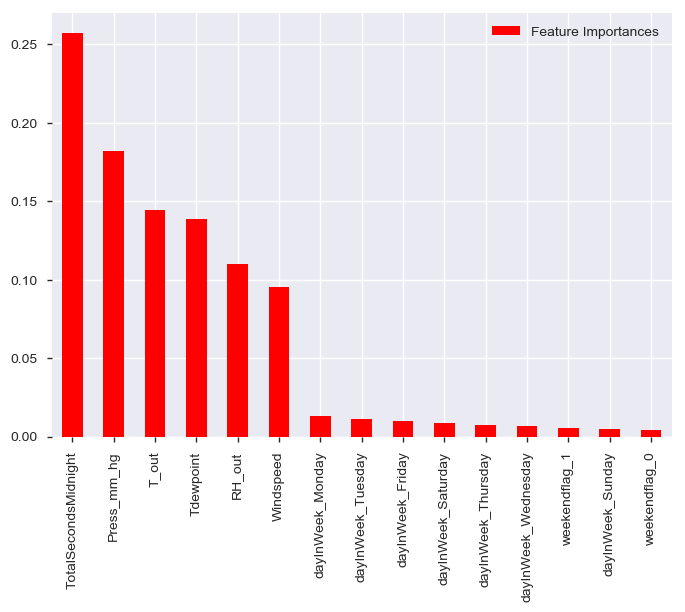

In [60]:
pd.DataFrame(wt_rf.feature_importances_,
             index=X_train_WT.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

In [61]:
wt_nn = MLPRegressor(activation='relu',
                     alpha=0.05,
                     learning_rate='adaptive',
                     solver='adam')
wt_nn.fit(X_WT_train_scaled,Y_WT_train_scaled)
model_stats_WT(wt_nn,'Weather & Time Only NN Model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Weather & Time Only Linear Model,0.058298,0.051950,inf,inf,0.034357,0.064387,0.117875,0.092430
0,Weather & Time Only RF Model,0.038426,0.011365,inf,inf,0.496435,0.935334,0.085122,0.024300
0,Weather & Time Only NN Model,0.055923,0.046793,inf,inf,0.072266,0.141606,0.115538,0.088534


In [62]:
pd.concat([error_metric,error_metric_nl,error_metric_nw,error_metric_th,error_metric_wt]).to_csv(path+'/'+'Evaluation.csv')